In [2]:
import numpy as np
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt 
# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

In [3]:
n = 5 # number of bits for state
# note: starts to take a while for n>5
num_qubits = n + 1 # 1 additional bit for coin flip


In [4]:
increment_circuit = QuantumCircuit(n, name='add1')
for i in range(n - 1):
    increment_circuit.mcx([j for j in range(n - 1 - i)], n - 1 - i)
increment_circuit.x(0)

# increment_circuit.draw()

increment_gate = increment_circuit.to_gate()
controlled_increment_gate = increment_gate.control()

In [5]:
decrement_circuit = QuantumCircuit(n, name='sub1')
decrement_circuit.x(0)
for i in range(n - 1):
    decrement_circuit.mcx([j for j in range(i+1)], i+1)

# decrement_circuit.draw()

decrement_circuit = decrement_circuit.to_gate()
controlled_decrement_gate = decrement_circuit.control()

In [10]:
num_steps = min(11, 2**(n-1) - 1)
# should only do at most 2^(n-1) - 1 steps (right bound for signed integer)
trials = 1000

qc = QuantumCircuit(num_qubits, n)

# first qubit is coin flip
# other qubits are state/position qubits, with one bit for sign (leftmost bit)

# for symmetric distribution
# qc.h(0)
# qc.s(0)

for i in range(num_steps):
    qc.h(0)
    # controlled increment
    qc.append(controlled_increment_gate, [j for j in range(num_qubits)])
    
    
    # controlled decrement
    qc.x(0)
    qc.append(controlled_decrement_gate, [j for j in range(num_qubits)])
    qc.x(0)
    
qc.draw()

# Map the quantum measurement to the classical bits
qc.measure([i+1 for i in range(n)], [i for i in range(n)])

# Execute the circuit on the qasm simulator
job = execute(qc, simulator, shots=trials)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(qc)
print("\nTotal counts (signed binary representation):", counts)

def to_decimal(num):
    if num[0]=='0':
        return int(num, 2)
    else:
        return int(num, 2) - (1 << len(num))

distribution = {}
for x in counts:
    distribution[to_decimal(x)] = counts[x]/trials

print("\nStates and Probabilities (decimal representation):", distribution)


Total counts (signed binary representation): {'00001': 66, '10111': 42, '11001': 218, '11011': 98, '11101': 63, '11111': 72, '00011': 77, '00101': 74, '00111': 250, '01001': 40}

States and Probabilities (decimal representation): {1: 0.066, -9: 0.042, -7: 0.218, -5: 0.098, -3: 0.063, -1: 0.072, 3: 0.077, 5: 0.074, 7: 0.25, 9: 0.04}


<BarContainer object of 10 artists>

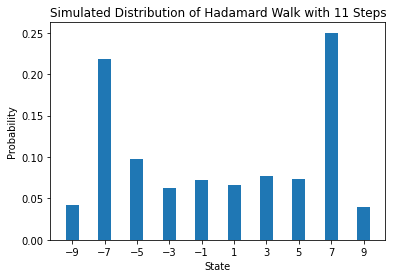

In [18]:
plt.xlabel("State")
if num_steps % 2 == 1:
    plt.xticks([2*i+1 for i in range(-(num_steps + 1)//2, (num_steps + 1)//2)])
else:
    plt.xticks([2*i for i in range(-num_steps//2, num_steps//2+1)])
plt.ylabel("Probability")
plt.title("Simulated Distribution of Hadamard Walk with %s Steps" % num_steps)
plt.bar(list(distribution.keys()), list(distribution.values()))
